In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
NUM_PASSBANDS = 6

## Input

In [3]:
preprocessed_data = np.load('mockdata.npz',allow_pickle=True)
times = preprocessed_data["times"]
fluxes = preprocessed_data["fluxes"]
flux_errs = preprocessed_data["flux_errs"]
filters = preprocessed_data["filters"]

## Preprocessing

In [4]:
# standardize times to have all events start at t=0
for i, e_times in enumerate(times):
    e_times = [t-e_times[0] for t in e_times]
    times[i] = np.array(e_times)
times

array([array([ 0.        ,  8.01786667, 10.026     , 12.63306667, 14.69293333]),
       array([ 0.        ,  1.3174    ,  1.99613333,  4.68206667, 12.641     ,
       53.2       ]),
       array([0.00000000e+00, 9.00000000e-03, 6.68466667e-01, 2.00326667e+00,
       7.97920000e+00, 1.92606000e+01, 2.45989333e+01, 2.79450000e+01,
       4.38816667e+01]),
       ...,
       array([0.        , 0.05573333, 1.97613333, 2.72506667, 4.058     ]),
       array([ 0.        ,  0.6748    ,  1.33133333,  3.3436    ,  4.0294    ,
        5.3574    , 16.6206    , 17.89873333, 21.92713333, 25.931     ,
       27.26413333]),
       array([ 0.        ,  3.9756    ,  5.9764    , 12.04353333, 13.99273333])],
      dtype=object)

In [5]:
# sanity checks
print(fluxes[0])
print(filters[0])

[-1.135273   -2.41777785 -3.26497326 -1.91166812 -2.87682809]
['1' '4' '4' '2' '4']


In [6]:
# TODO: add zero-flux points for each passband before first times and after last times

## Utility Functions

In [7]:
def plot_event(event_id):
    time_row = times[event_id]
    flux_row = fluxes[event_id]
    filter_row = filters[event_id]
    
    for passband, color in zip(range(NUM_PASSBANDS), ("blue", "cyan", "green", "yellow", "orange", "red")):
        good_ixes = np.where(filter_row==str(passband))
        plt.plot(time_row[good_ixes], flux_row[good_ixes], color=color)
        
        print()
    
    plt.title('Light Curve {}'.format(event_id))
    plt.show()

In [8]:
def plot_fit(params, event_id):
    num_times = len(times[event_id])
    
    for passband, color in zip(range(NUM_PASSBANDS), ("blue", "cyan", "green", "yellow", "orange", "red")):
        PPP = 2  # params per passband
        points = np.zeros((num_times, 2))
        
        slope, intercept = params[passband*PPP:(passband+1)*PPP]
        
        # generate points
        for i, t in enumerate(times[event_id]):
            f = slope*t + intercept
            points[i] = [t, f]
        
        plt.plot(points[:,0], points[:,1], color=color)
        
    plt.title('Intermediate Regression Curve {}'.format(event_id))
    plt.show()

## LinReg Prototype

In [9]:
def GetFeatures(ix):
    e_fluxes = [[] for i in range(NUM_PASSBANDS)]
    
    for passband, time, flux in zip(filters[ix], times[ix], fluxes[ix]):
        e_fluxes[int(passband)].append((time, flux))
    
    features = [0 for i in range(NUM_PASSBANDS*2)]
        
    for passband in range(NUM_PASSBANDS):        
        if len(e_fluxes[passband]) >= 1:
            X = np.array(e_fluxes[passband])
            
            linreg = LinearRegression()
            linreg.fit(X[:,0:1], X[:,1:2])
            
            features[passband*2] = linreg.coef_[0][0]
            features[1+passband*2] = linreg.intercept_[0]
    
    return features

[[ 0.       -1.135273]]
[[12.63306667 -1.91166812]]
[[ 8.01786667 -2.41777785]
 [10.026      -3.26497326]
 [14.69293333 -2.87682809]]








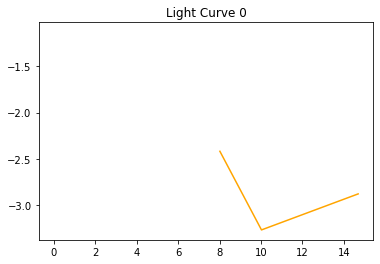

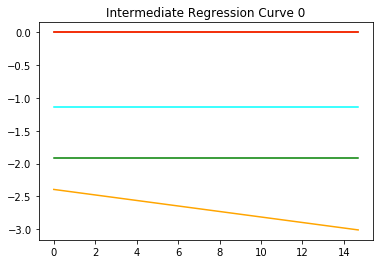


[[ 1.3174     -2.63766659]
 [53.2        -1.36611412]]
[[ 1.99613333 -3.34984366]
 [ 4.68206667 -3.46278498]]
[[ 0.         -3.53048477]
 [12.641      -3.6831391 ]]








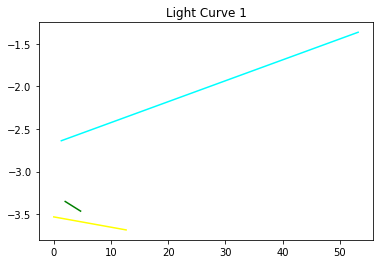

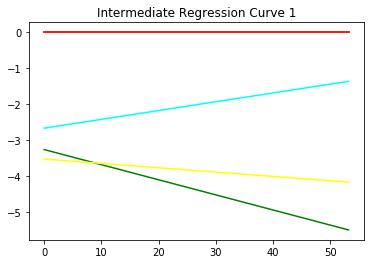


[[ 0.         -3.1623543 ]
 [ 0.66846667 -3.05235207]
 [ 2.00326667 -3.15424248]
 [19.2606     -2.73080791]
 [24.59893333 -2.73110452]
 [43.88166667 -1.86591734]]
[[ 7.9792    -3.1423869]
 [27.945     -2.2406691]]
[[ 0.009      -3.02903839]]








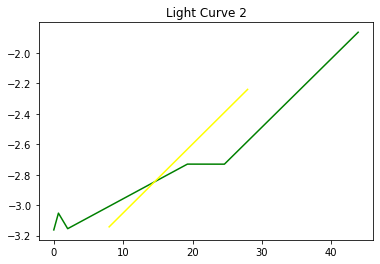

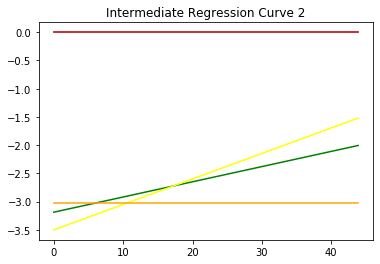


[[ 0.64733333 -2.54622573]
 [ 7.93433333 -2.63993495]]
[[ 0.         -2.73555308]
 [ 7.34353333 -3.06229302]
 [11.2362     -3.12971166]
 [21.8754     -2.35403876]]








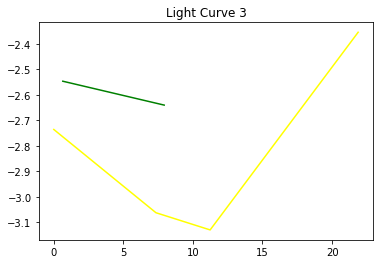

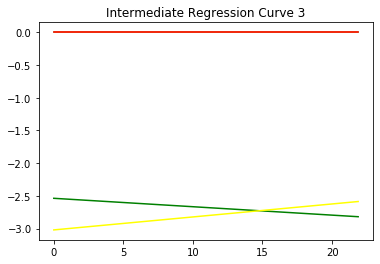


[[ 2.6306     -3.9778184 ]
 [13.9594     -2.67246261]]
[[ 3.35553333 -3.86227306]]
[[17.9712     -3.23644788]]
[[ 0.         -3.71244186]]








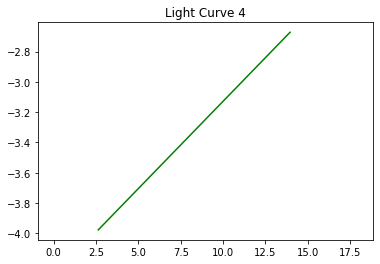

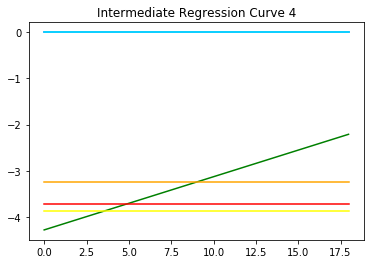


[[ 2.6516    -3.5912252]]
[[15.98566667 -4.52371921]
 [16.60133333 -4.46123055]
 [21.9504     -4.06433902]]
[[ 0.         -3.3517993 ]
 [19.99033333 -4.39102698]
 [23.26186667 -4.09339064]
 [44.63813333 -3.0323215 ]]
[[10.69173333 -4.45897372]
 [21.24366667 -4.05099627]]
[[ 6.636      -4.30126879]]








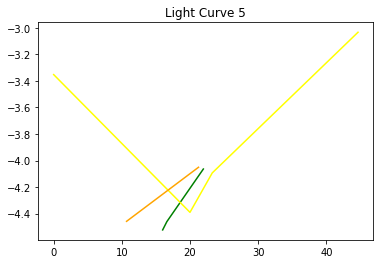

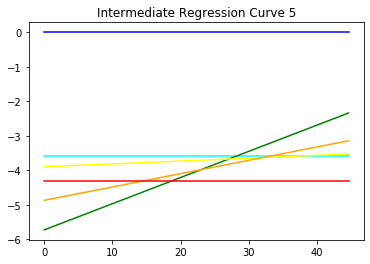


[[11.99       -4.44044738]
 [17.28793333 -4.22821652]]
[[23.35426667 -3.92704494]
 [35.24326667 -3.32337766]
 [36.53613333 -3.37244314]]
[[ 0.         -3.24799166]
 [22.01386667 -3.72825146]]








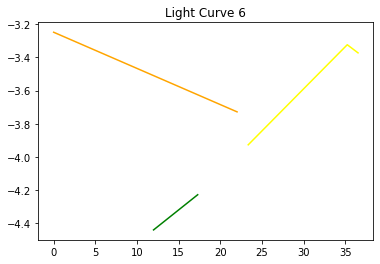

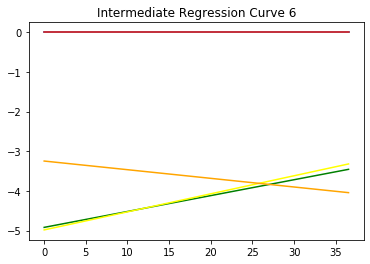


[[ 0.         -3.71426484]
 [33.2378     -3.1815072 ]]
[[ 4.1092     -4.09627999]
 [16.11386667 -4.08367867]
 [20.77753333 -3.63438519]]








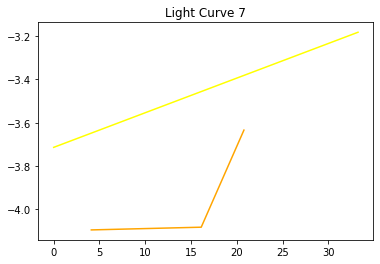

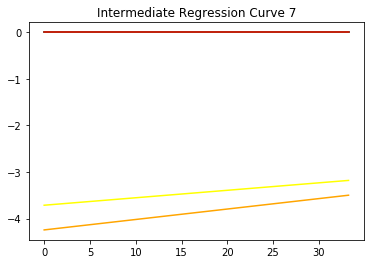


[[ 5.96286667 -2.00011546]]
[[ 5.34473333 -3.4904095 ]]
[[ 4.71526667 -3.27939849]
 [ 9.3272     -3.21991695]]
[[ 0.         -2.49074506]]








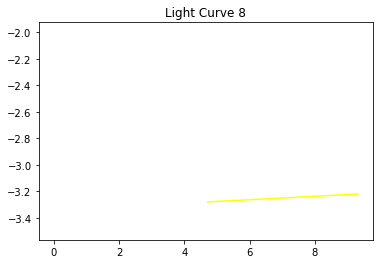

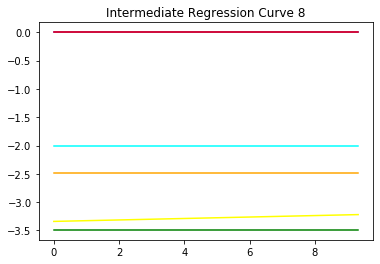


[[ 2.6456     -2.89262638]]
[[ 8.65213333 -3.69389224]
 [16.64446667 -2.8957312 ]]
[[14.6418     -3.48972792]]
[[ 0.         -3.47274398]
 [ 1.99886667 -4.12604767]
 [13.30266667 -3.41025172]]








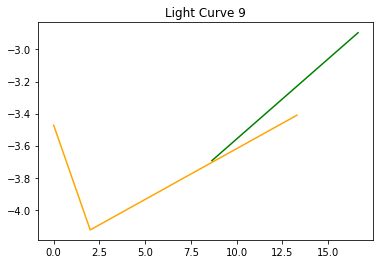

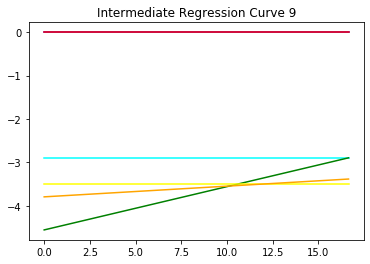

array([[ 0.        ,  0.        ,  0.        , -1.135273  ,  0.        ,
        -1.91166812,  0.        ,  0.        , -0.04197884, -2.39510882,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.02450826, -2.66995378, -0.04204919,
        -3.26590788, -0.01207613, -3.53048477,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.0269367 ,
        -3.18870075,  0.04516312, -3.50275246,  0.        , -3.02903839,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.01285978,
        -2.53790117,  0.01983491, -3.02100507,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.11522454,
        -4.28092808,  0.        , -3.86227306,  0.        , -3.23644788,
         0.        , -3.71244186],
       [ 0.        ,  0.        ,  0.        , -3.5912252 ,  0.07591113,
        -5.72976155,  

In [10]:
rows = []
for i in range(10):
    features = GetFeatures(i)
    rows.append(features)
    plot_event(i)
    plot_fit(features, i)
    print()

X = np.array(rows)
X

In [11]:
ss = StandardScaler(with_mean=False)
X_scaled = ss.fit_transform(X)

X_scaled

array([[ 0.        ,  0.        ,  0.        , -0.83287679,  0.        ,
        -1.22268907,  0.        ,  0.        , -1.91687047, -1.55552706,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  3.33333333, -1.95877338, -0.85672145,
        -2.088851  , -0.66444713, -2.90454658,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.54881552,
        -2.03946988,  2.48494436, -2.88173107,  0.        , -1.96723887,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.26200862,
        -1.62322319,  1.09134708, -2.48539521,  0.        ,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  2.34761575,
        -2.73805056,  0.        , -3.17751037,  0.        , -2.10194301,
         0.        , -2.30852975],
       [ 0.        ,  0.        ,  0.        , -2.63465098,  1.54663383,
        -3.66471395,  

## DBSCAN Clustering

In [12]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_scaled)
kmeans.labels_

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1], dtype=int32)

In [13]:
dbscan = DBSCAN(eps=3.0).fit(X_scaled)
labels = dbscan.labels_
labels

array([-1, -1,  0,  0, -1, -1,  0,  0,  0, -1])

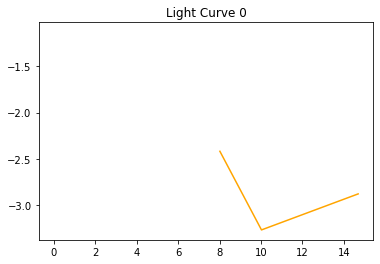

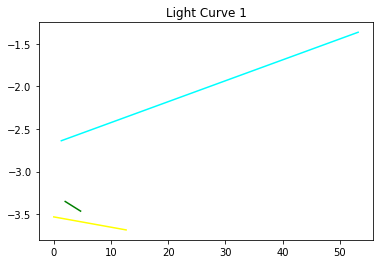

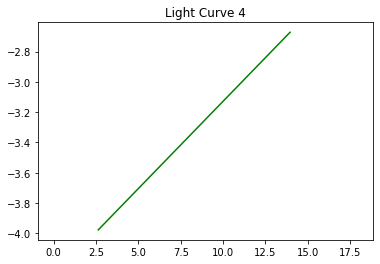

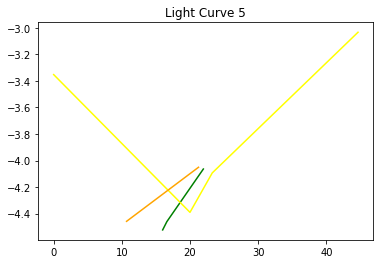

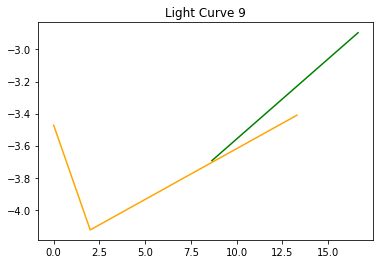

In [14]:
for i, l in enumerate(labels):
    if l == -1:
        plot_event(i)